In [1]:
from __future__ import division
import numpy as np
from scipy.linalg import expm # matrix exponential solves linear system
import matplotlib.pyplot as plt
%matplotlib inline

CABLE_LEN = 800 # microns
DC = 10 # diffusion coeff [microns^2 s^-1]
N_SYN = 6 # number of demand hotspots

def get_matrix(N):
    """Calculates the state-transition matrix, A"""
    # Calculate target profile, y
    syn_loc = np.linspace(0.1,0.9,N_SYN)
    x = np.linspace(0,1,N)
    y = np.zeros(N)
    for i in syn_loc:
        y += 0.5*np.exp(-abs(x - x[int(i*N)])*100)
    
    # compartment size
    cs = CABLE_LEN/N
    
    # detachment rates
    c = 5e-4*y
    
    # trafficking rates, normalized to diffusion coefficient
    a = np.ones(N-1)*(DC/(cs**2)/2.)
    b = np.ones(N-1)*(DC/(cs**2)/2.)
    
    mid = -c
    mid[:-1] -= a
    mid[1:]  -= b
    A1 = np.diag(a, -1) + np.diag(mid) + np.diag(b, 1) # Upper-right block
    A2 = np.diag(c) # Lower-left block
    
    # State-transition matrix
    A = np.array(np.bmat([[A1,np.zeros((N,N))],[A2,np.zeros((N,N))]]))
    
    # initial condition
    u0 = np.zeros(2*N)
    u0[0] = np.sum(y)
    
    return A,u0

def sim(N,T=np.logspace(3,6,5),show_plot=False):
    A,u0 = get_matrix(N)
    u = np.empty((2*N,len(T)))
    for i,t in enumerate(T):
        u[:,i] = np.dot(expm(A*t),u0)
    return u

def time_to_ss(N,perc_error=0.1,tol=1.0):
    # calculate number of seconds to reach steady-state (within perc_error)
    A,u0 = get_matrix(N)
    
    upper_bound = 1e10
    lower_bound = 0
    while (upper_bound-lower_bound)>tol:
        tt = lower_bound + (upper_bound-lower_bound)/2
        u = np.dot(expm(A*tt),u0)
        if np.sum(u[:N]) > perc_error:
            # not converged to steady-state
            lower_bound = tt
        else:
            # converged to steady-state
            upper_bound = tt
    return (lower_bound + (upper_bound-lower_bound)/2)/60

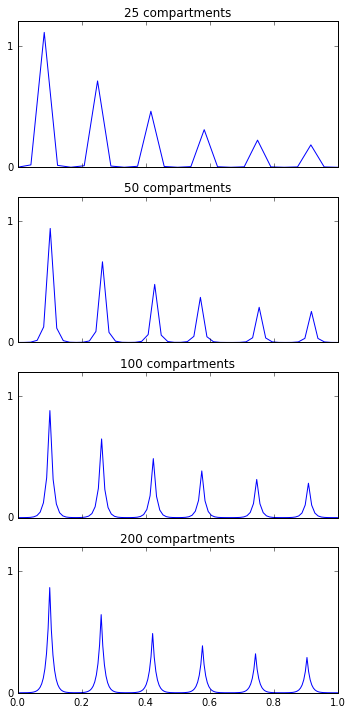

In [2]:
plt.figure(figsize=(5,10))
xt = [0,0.2,0.4,0.6,0.8,1]
for s,n in enumerate([25,50,100,200]):
    u = sim(n);
    plt.subplot(4,1,s+1)
    plt.plot(np.linspace(0,1,n),u[n:,-1])
    plt.title(str(n)+' compartments')
    if s<3: plt.xticks(xt,[])
    plt.ylim([0,1.2])
    plt.yticks([0,1])
plt.tight_layout()
plt.savefig('a.eps')

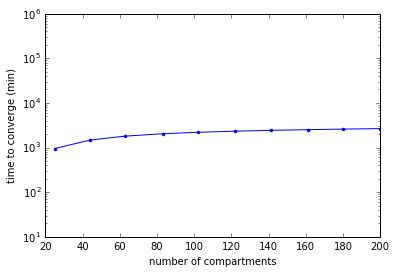

In [3]:
nlevs = [int(x) for x in np.linspace(25,200,10)]
tss = []
for N in nlevs:
    tss.append( time_to_ss(N) )
plt.plot(nlevs,tss,'.-')
plt.ylim([10,1e6])
plt.yscale('log')
plt.xlabel('number of compartments')
plt.ylabel('time to converge (min)')
plt.savefig('b.eps')